In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.fft as fft
import scipy as sp
import asp_func as f

# 1)
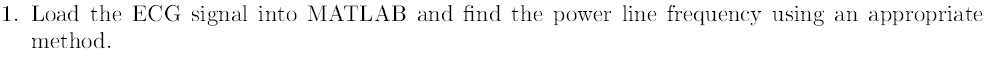

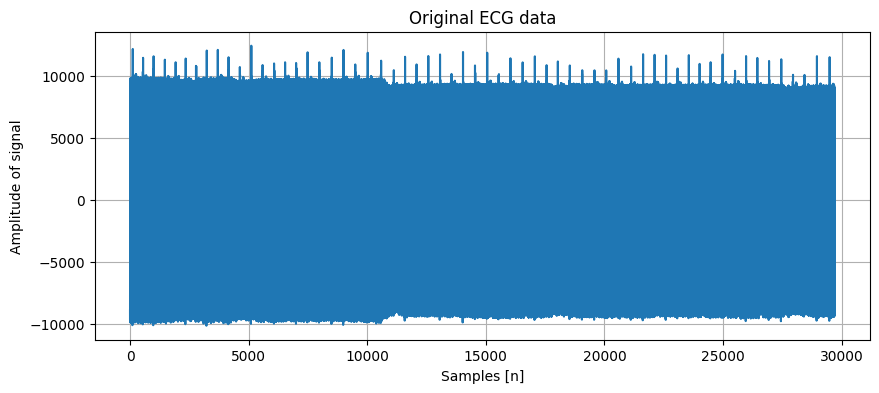

In [2]:
ecg_signal = np.loadtxt("ecg.dat") # Desired signal
N = len(ecg_signal)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ecg_signal)
ax.set_title("Original ECG data")
ax.set_xlabel("Samples [n]")
ax.set_ylabel("Amplitude of signal")
ax.grid()
plt.show()

# 2)



The filter taps should ideally cover at least one full cycle of the interference waveform (in this case, the 50 Hz powerline interference)
Given a sampling rate fs=500 Hzfs=500Hz, each cycle of the interference (50 Hz) corresponds to fs/f0=500/50=10fs/f0=500/50=10 samples per cycle.

In [3]:
fs = 500
f0 = 50
Nc = int(fs/f0)
Nc

10

# 3)
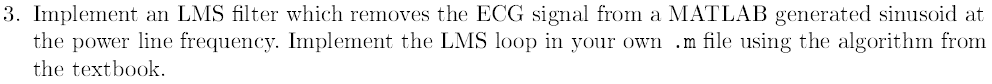

In [4]:
def LMS(x, d, order, step): #Takes data sequence (x), desired signal (d), number of filter taps (order), step-size (step)
    N = len(x)
    ws = np.zeros((N, order))
    ys = np.zeros(N)
    error = np.zeros(N)
    w = np.zeros(order)
    x_in = np.zeros(order)
    for k in range(N):
        ws[k] = w
        x_in = np.insert(x_in, 0, x[k])
        x_in = np.delete(x_in, -1)
        ys[k] = np.dot(w, x_in)
        error[k] = d[k] - ys[k]
        w = w + 2*step*error[k]*x_in
    return ws, ys, error

# 4)
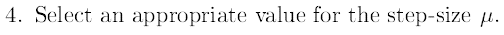

In [5]:
f0 = 50 #Powerline noise frequency
fs = 500 #Sampling frequency of system
n_samples = len(ecg_signal)
t = np.arange(n_samples) / fs

# Generate reference sinusoidal interference (50 Hz)
reference_signal_normal = np.cos(2 * np.pi * f0 * t)

#Autocorrelation matrix constructed
ACR, lags = f.autocorrelation(reference_signal_normal, Nc)
R = sp.linalg.toeplitz(np.flip(ACR[:Nc]))

#Maximum step-size determined from the trace of the autocorrelation matrix
μ_max = 1/(3*np.trace(R))
μ_max

np.float64(0.08240730639667648)

# 5)
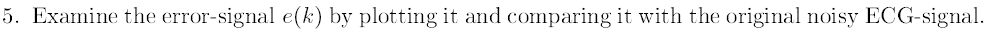

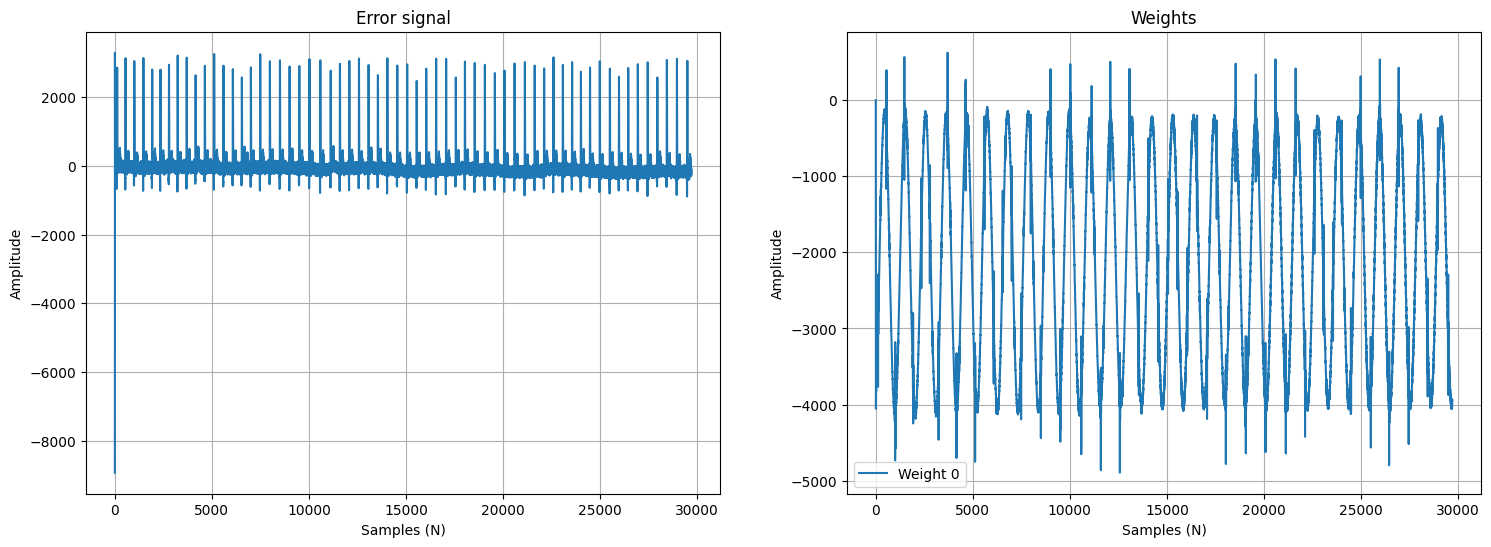

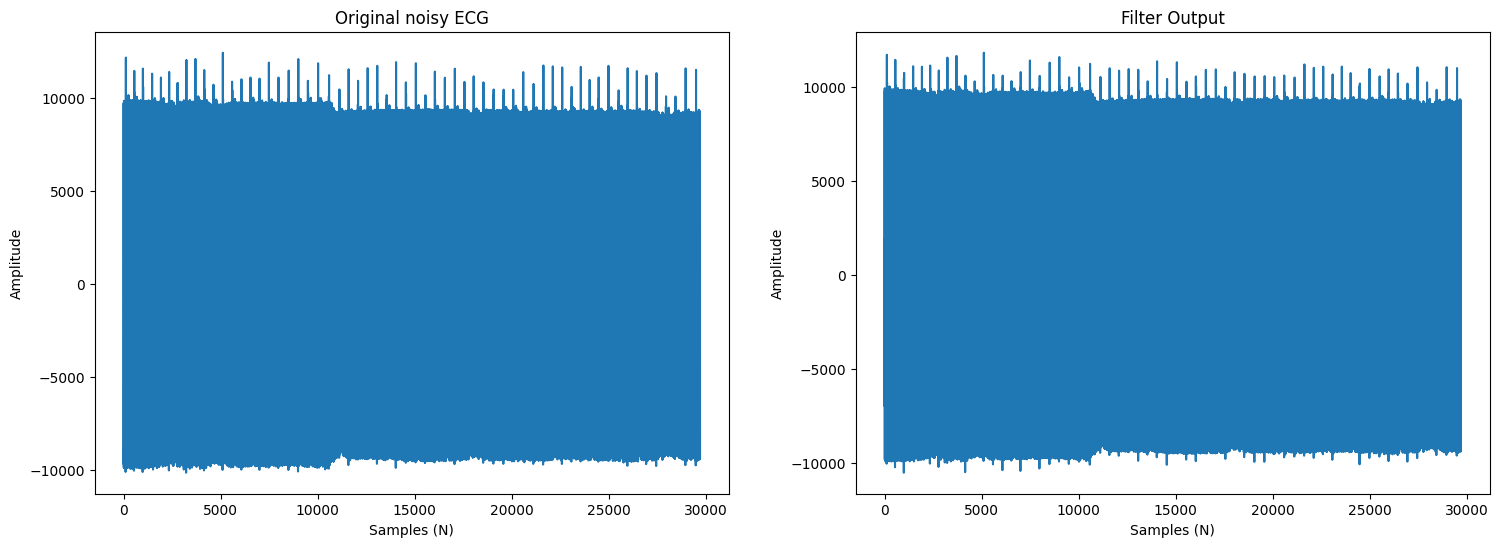

In [6]:
#Determined optimum weights with LMS
ws, ys, err = LMS(reference_signal_normal, ecg_signal, Nc, μ_max)

#From the plot below, we can see that we have strong oscillations in the weights over iterations. 
#It could indicate that 50 Hz is not being found. 
fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].plot(err)
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Samples (N)")
ax[0].set_title("Error signal")
ax[0].grid()
for w in range(1):
    ax[1].plot(ws[:,w], label=f"Weight {w}")
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Samples (N)")
ax[1].set_title("Weights")
plt.show()

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].plot(ecg_signal)
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Samples (N)")
ax[0].set_title("Original noisy ECG")
ax[1].plot(-ys)
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Samples (N)")
ax[1].set_title("Filter Output")
plt.show()

# 6)
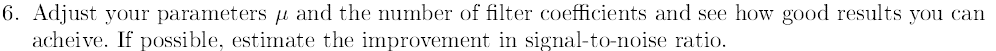

Frequency of maximum energy: 49.52695195447965


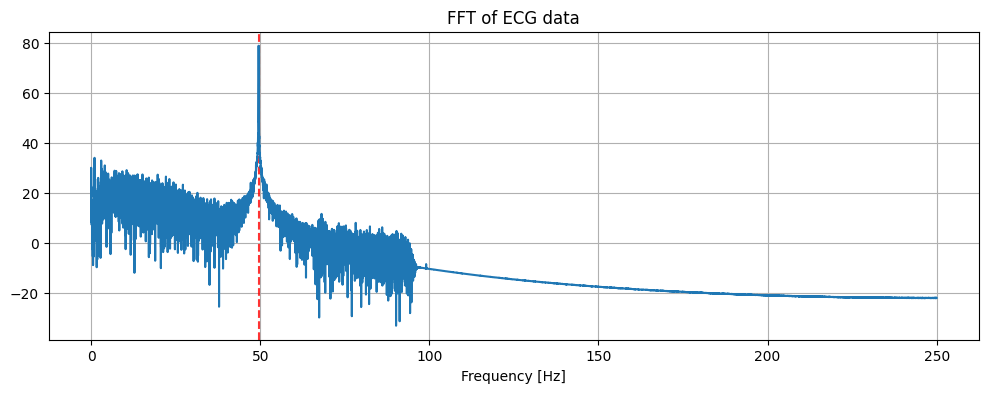

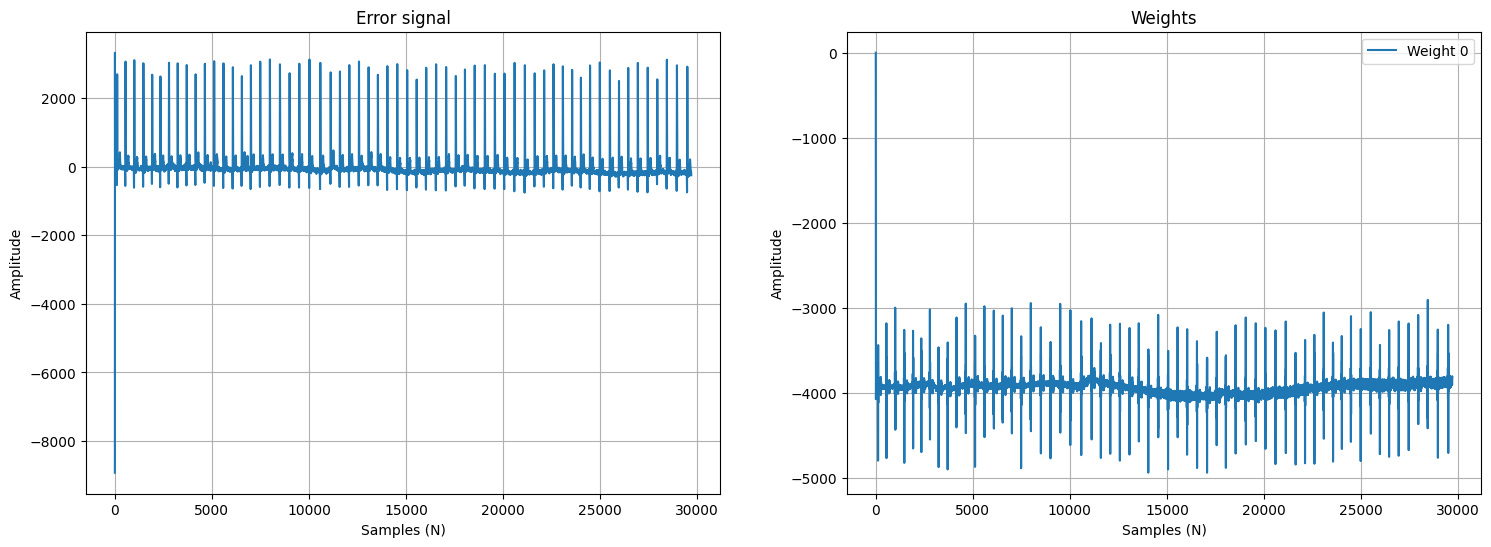

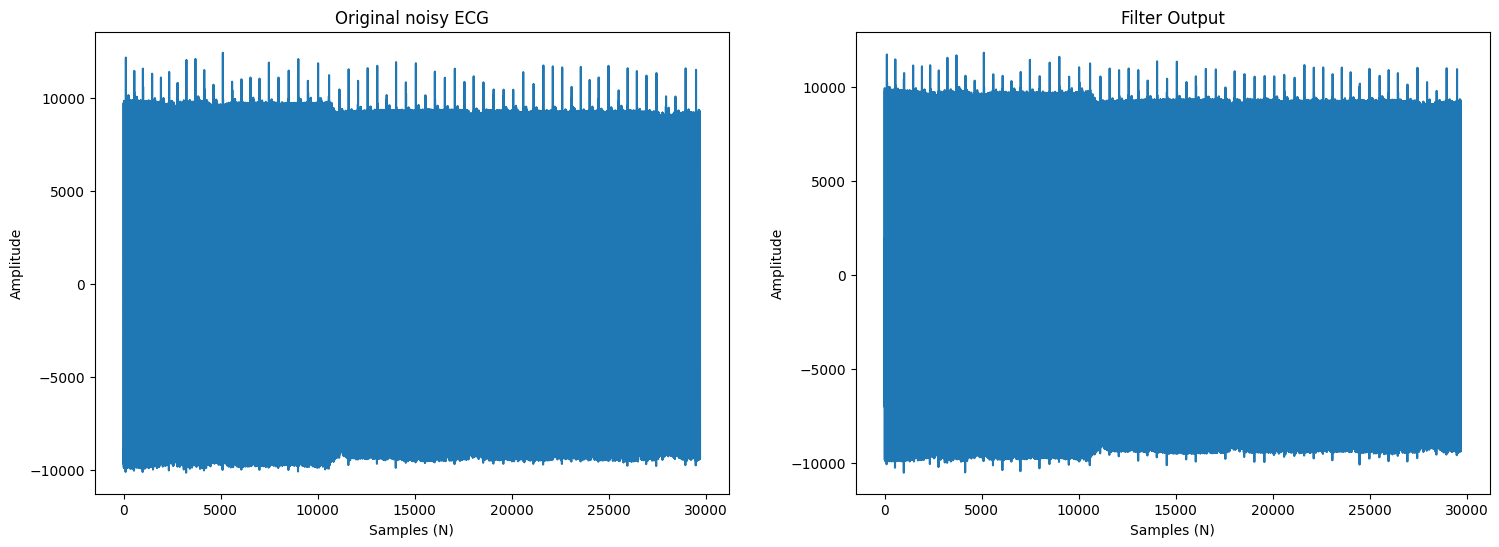

In [40]:
data_fft = fft.fft(ecg_signal)
fft_freq = fft.fftfreq(N, 1/fs)[:N//2]
fft_db = 20*np.log10(2.0/N * abs(data_fft[0:N//2]))

idx_max = np.argmax(fft_db)
freq_max = fft_freq[idx_max]
print("Frequency of maximum energy:",freq_max)

fig, ax = plt.subplots(figsize=(12,4))
ax.vlines(freq_max, 0, 1, transform=ax.get_xaxis_transform(), colors='r', linestyles='dashed', alpha=0.8)
ax.plot(fft_freq, fft_db)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("")
ax.set_title("FFT of ECG data")
ax.grid()
plt.show()

# Update the reference signal
f0 = freq_max
reference_signal_FFT = np.cos(2 * np.pi * f0 * t)

#Autocorrelation matrix constructed
ACR, lags = f.autocorrelation(reference_signal_FFT, Nc)
R = sp.linalg.toeplitz(np.flip(ACR[:Nc]))

#Maximum step-size determined from the trace of the autocorrelation matrix
μ_max = 1/(3*np.trace(R))
μ_max

# Determined optimum weights with LMS
ws2, ys2, err2 = LMS(reference_signal_FFT, ecg_signal, Nc, μ_max)

# From the plot below, we can see that we have strong oscillations in the weights over iterations. 
# It could indicate that 50 Hz is not being found. 
fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].plot(err2)
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Samples (N)")
ax[0].set_title("Error signal")
ax[0].grid()
for w in range(1):
    ax[1].plot(ws2[:,w], label=f"Weight {w}")
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Samples (N)")
ax[1].set_title("Weights")
plt.show()

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].plot(ecg_signal)
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Samples (N)")
ax[0].set_title("Original noisy ECG")
ax[1].plot(-ys2)
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Samples (N)")
ax[1].set_title("Filter Output")
plt.show()

In [41]:
def calculate_snr(signal, noise):
    """
    Calculate Signal-to-Noise Ratio (SNR) in dB.
    """
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

original_snr_normal = calculate_snr(ecg_signal, ecg_signal - reference_signal_normal)
original_snr_FFT = calculate_snr(ecg_signal, ecg_signal - reference_signal_FFT)
error1_snr = calculate_snr(ecg_signal, err)
error2_snr = calculate_snr(ecg_signal, err2)
snr_improvement1 = error1_snr - original_snr_normal
snr_improvement2 = error2_snr - original_snr_FFT
print("Original SNR = ", original_snr_normal)
print("FFT SNR = ", original_snr_FFT)
print("LMS denoise SNR1 = ", error1_snr)
print("LMS denoise SNR2 = ", error2_snr)
print("SNR improvement1 = ", snr_improvement1)
print("SNR improvement2 = ", snr_improvement2)
print("SNR tuned parameter diff = ", snr_improvement2-snr_improvement1)

Original SNR =  6.154922522515314e-07
FFT SNR =  -0.000855618454974967
LMS denoise SNR1 =  23.512051883402005
LMS denoise SNR2 =  23.768072018992985
SNR improvement1 =  23.512051267909754
SNR improvement2 =  23.76892763744796
SNR tuned parameter diff =  0.2568763695382046


# 7), 8), 9)
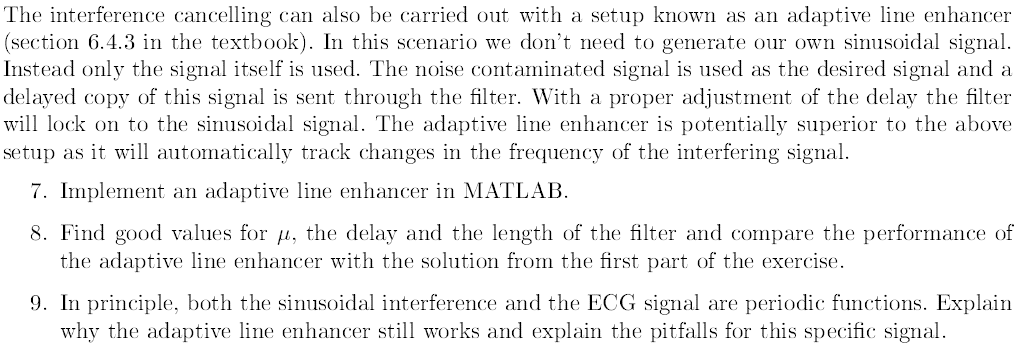

Max µ for ALE with delay 2 = 9.068070020939875e-10
Max µ for ALE with delay 3 = 9.068375312325291e-10
Max µ for ALE with delay 4 = 9.068680603710703e-10
Max µ for ALE with delay 5 = 9.068985895096116e-10
Max µ for ALE with delay 6 = 9.069291186481529e-10
Max µ for ALE with delay 7 = 9.069596477866943e-10
Max µ for ALE with delay 8 = 9.069901769252357e-10
SNR Adapative Line Enhancer =  24.01088522823711
Improvements over LMS =  0.24195759078915202


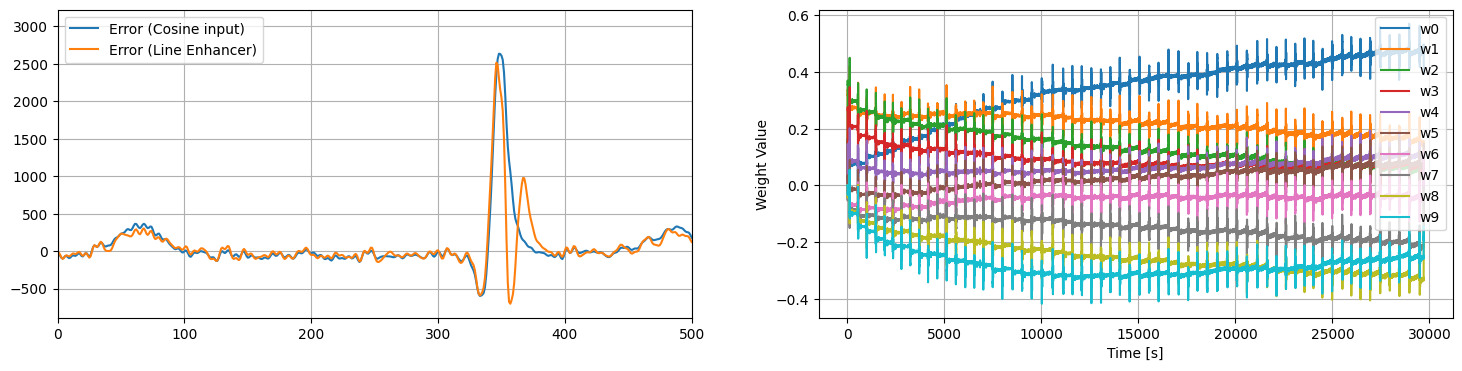

Frequency of maximum energy: 1.0100670011110737


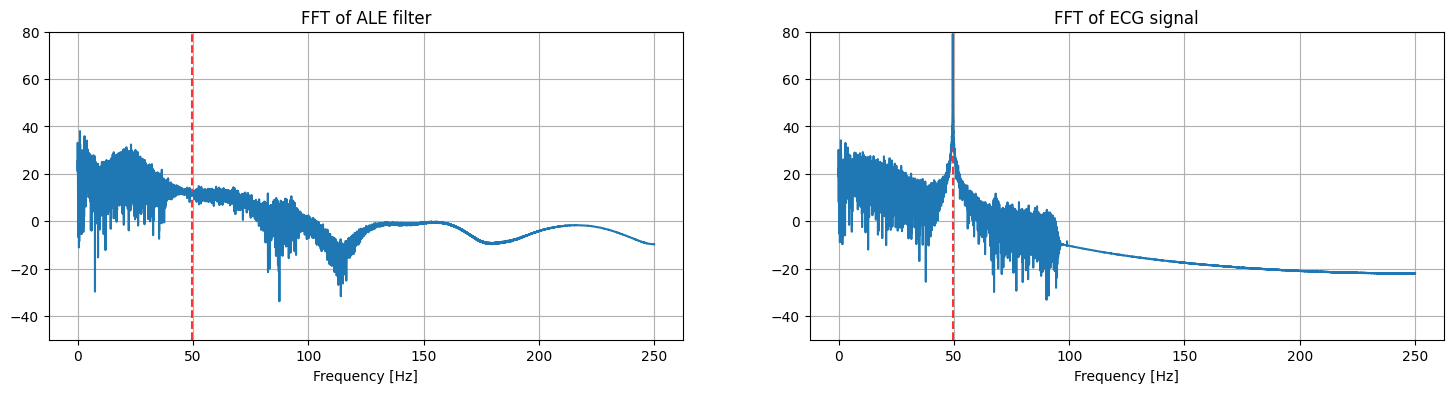

In [ ]:
delay = np.array([2,3,4,5,6,7,8])
des = np.append(ecg_signal, [0]*delay) #Desired Signal
des_delay = np.insert(ecg_signal, 0, [0]*delay) #Input signal
Nc = 10

#Autocorrelation matrix constructed
ACR, lags = f.autocorrelation(des_delay, Nc)
R = sp.linalg.toeplitz(np.flip(ACR[:Nc]))

#Maximum step-size determined from the trace of the autocorrelation matrix
μ_max = 1/(3*np.trace(R))
μ_li = μ_max
print("Max µ ALE = ", µ_li)

ws_li, ys_li, err_li = LMS(des_delay, des, Nc, μ_li)


# Define the delays to test
delays = np.array([2, 3, 4, 5, 6, 7, 8])
Nc = 10  # Number of coefficients for the filter

# Store results for each delay
results = []

for delay in delays:
    # Define the desired signal with padding at the end
    des = np.append(ecg_signal, [0] * delay)

    # Define the input signal (delayed version of the ECG) with padding at the start
    des_delay = np.insert(ecg_signal, 0, [0] * delay)

    # Autocorrelation matrix construction
    ACR, lags = f.autocorrelation(des_delay, Nc)
    R = sp.linalg.toeplitz(np.flip(ACR[:Nc]))

    # Calculate the maximum step size for stability
    μ_max = 1 / (3 * np.trace(R))
    μ_li = μ_max
    print(f"Max µ for ALE with delay {delay} = {μ_li}")

    # Apply the LMS filter
    ws_li, ys_li, err_li = LMS(des_delay, des, Nc, μ_li)

    # Store the results
    results.append({
        "delay": delay,
        "μ": μ_li,
        "weights": ws_li,
        "output": ys_li,
        "error": err_li
    })

snr_ALE = calculate_snr(ecg_signal, err_li)
print("SNR Adapative Line Enhancer = ", snr_ALE)
print("Improvements over LMS = ", snr_ALE - snr_improvement2)

fig, ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(err2[2000:3000], label="Error (Cosine input)")
ax[0].plot(err_li[2000:3000], label="Error (Line Enhancer)")
ax[0].set_xlim(0,500)
ax[0].grid()
ax[0].legend()
for w in range(Nc):
    ax[1].plot(ws_li[:,w], label=f"w{w}")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Weight Value")
ax[1].legend()
ax[1].grid()
plt.show()

# FFT
data_fft_ALE = fft.fft(err_li)
fft_freq_ALE = fft.fftfreq(N, 1/fs)[:N//2]
fft_db_ALE = 20*np.log10(2.0/N * abs(data_fft_ALE[0:N//2]))

idx_max_ALE = np.argmax(fft_db_ALE)
freq_max_ALE = fft_freq[idx_max_ALE]
print("Frequency of maximum energy:",freq_max_ALE)

fig, ax = plt.subplots(1,2,figsize=(18,4))
ax[0].vlines(freq_max, 0, 1, transform=ax[0].get_xaxis_transform(), colors='r', linestyles='dashed', alpha=0.8)
ax[0].plot(fft_freq_ALE, fft_db_ALE)
ax[0].set_ylabel("")
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylim(-50,80)
ax[0].set_title("FFT of ALE filter")
ax[0].grid()
ax[1].vlines(freq_max, 0, 1, transform=ax[1].get_xaxis_transform(), colors='r', linestyles='dashed', alpha=0.8)
ax[1].plot(fft_freq, fft_db)
ax[1].set_ylabel("")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylim(-50,80)
ax[1].set_title("FFT of ECG signal")
ax[1].grid()
plt.show()

C:\Users\thoma\AppData\Local\Temp\ipykernel_8908\1272389875.py:85: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())


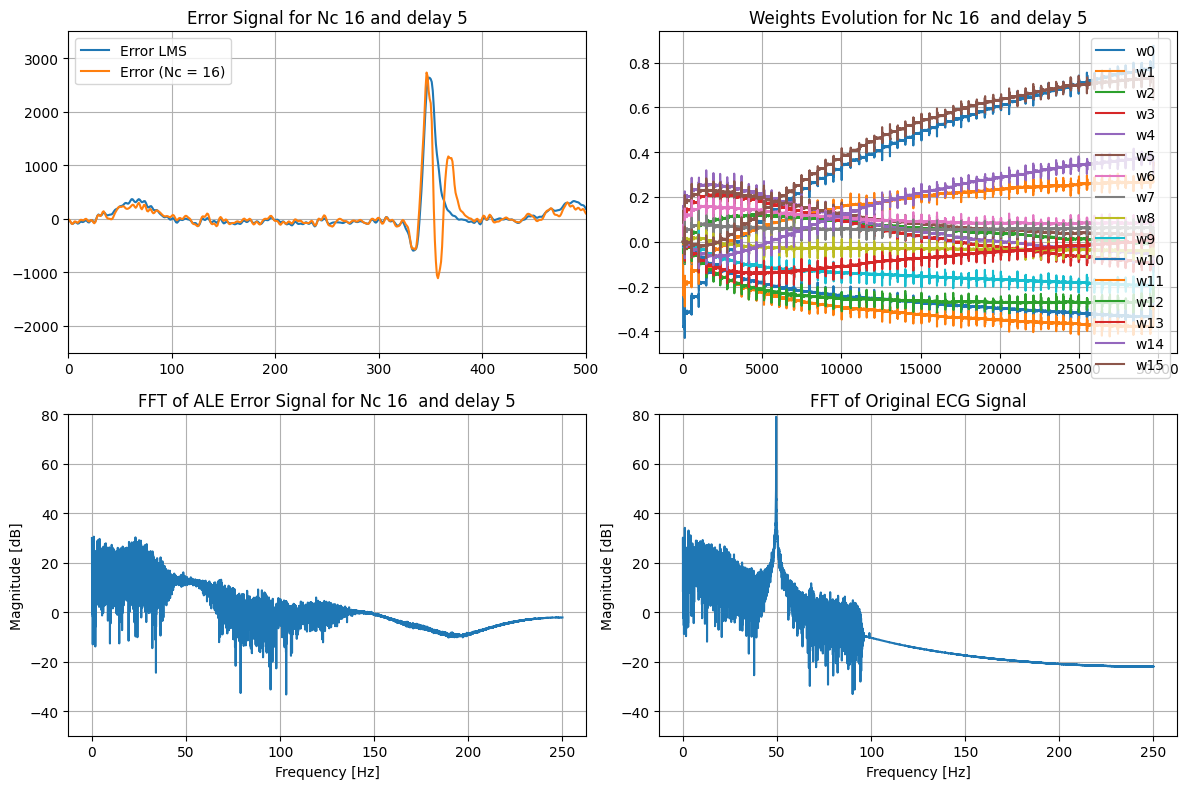

In [58]:
import numpy as np
import scipy as sp
import scipy.fft as fft
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

# Constants
fs = 500  # Sampling frequency in Hz
# delays = np.array([2, 3, 4, 5, 6, 7, 8])  # Delays to test
delay = 5
Ncs = np.array([6,8,10,12,14,16])  # Number of coefficients for the filter
frames = []  # To store frames for the GIF

# Set up figure for animation
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Loop through delays to generate frames
for Nc in Ncs:
    # Define the desired signal and delayed input signal
    des = np.append(ecg_signal, [0] * delay)
    des_delay = np.insert(ecg_signal, 0, [0] * delay)

    # Autocorrelation matrix and step size calculation
    ACR, lags = f.autocorrelation(des_delay, Nc)
    R = sp.linalg.toeplitz(np.flip(ACR[:Nc]))
    μ_max = 1 / (3 * np.trace(R))
    μ_li = μ_max

    # Apply the LMS filter (ALE setup)
    ws_li, ys_li, err_li = LMS(des_delay, des, Nc, μ_li)

    # FFT of the error signal for the current delay
    N = len(err_li)
    data_fft_ALE = fft.fft(err_li)
    fft_freq_ALE = fft.fftfreq(N, 1/fs)[:N//2]
    fft_db_ALE = 20 * np.log10(2.0 / N * abs(data_fft_ALE[0:N//2]))

    # FFT of the original ECG signal for comparison
    data_fft_ecg = fft.fft(ecg_signal)
    fft_freq_ecg = fft.fftfreq(len(ecg_signal), 1/fs)[:len(ecg_signal)//2]
    fft_db_ecg = 20 * np.log10(2.0 / len(ecg_signal) * abs(data_fft_ecg[0:len(ecg_signal)//2]))

    # Clear axes for updating
    axs[0, 0].cla()
    axs[0, 1].cla()
    axs[1, 0].cla()
    axs[1, 1].cla()

    # Plot the error signal for the current delay
    axs[0, 0].plot(err2[2000:3000], label=f"Error LMS")
    axs[0, 0].plot(err_li[2000:3000], label=f"Error (Nc = {Nc})")
    axs[0, 0].set_xlim(0, 500)
    axs[0, 0].set_ylim(-2500, 3500)
    axs[0, 0].set_title(f"Error Signal for Nc {Nc} and delay {delay}")
    axs[0, 0].legend()
    axs[0, 0].grid()

    # Plot the evolution of filter weights for the current Nc
    for w in range(Nc):
        axs[0, 1].plot(ws_li[:, w], label=f"w{w}")
    axs[0, 1].set_title(f"Weights Evolution for Nc {Nc}  and delay {delay}")
    axs[0, 1].legend()
    axs[0, 1].grid()

    # Plot the FFT of the ALE error signal for the current Nc
    axs[1, 0].plot(fft_freq_ALE, fft_db_ALE, label=f"Nc = {Nc}")
    axs[1, 0].set_ylim(-50, 80)
    axs[1, 0].set_xlabel("Frequency [Hz]")
    axs[1, 0].set_ylabel("Magnitude [dB]")
    axs[1, 0].set_title(f"FFT of ALE Error Signal for Nc {Nc}  and delay {delay}")
    axs[1, 0].grid()

    # Plot the FFT of the original ECG signal for comparison
    axs[1, 1].plot(fft_freq_ecg, fft_db_ecg)
    axs[1, 1].set_ylim(-50, 80)
    axs[1, 1].set_xlabel("Frequency [Hz]")
    axs[1, 1].set_ylabel("Magnitude [dB]")
    axs[1, 1].set_title("FFT of Original ECG Signal")
    axs[1, 1].grid()

    # Save the current frame
    plt.tight_layout()
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    frames.append(image)

# Save frames as a GIF
frames[0].save('ALE_animation_5.gif', save_all=True, append_images=frames[1:], duration=1000, loop=0)


# 10) 
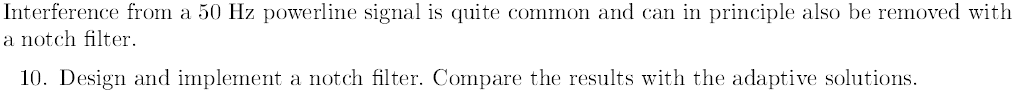

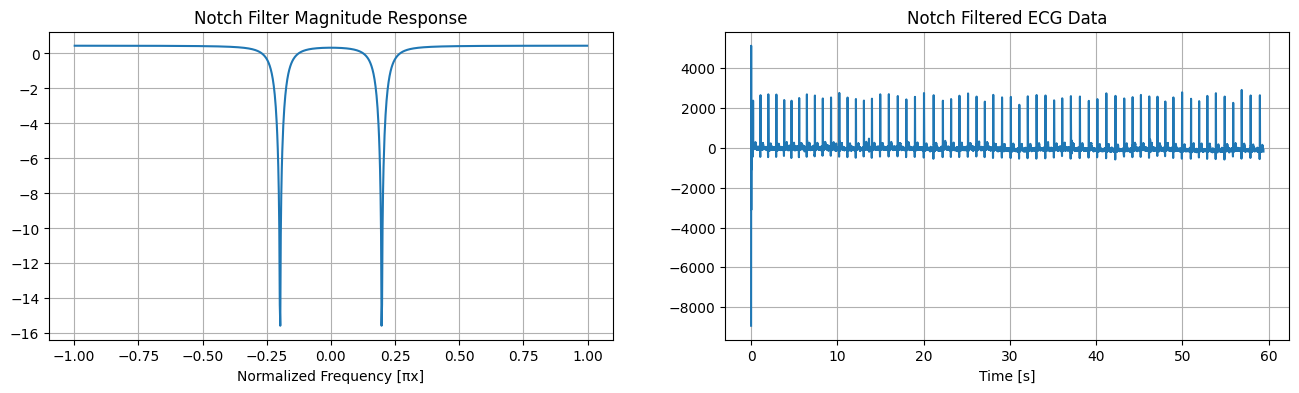

Frequency of maximum energy: 1.0098969905069684


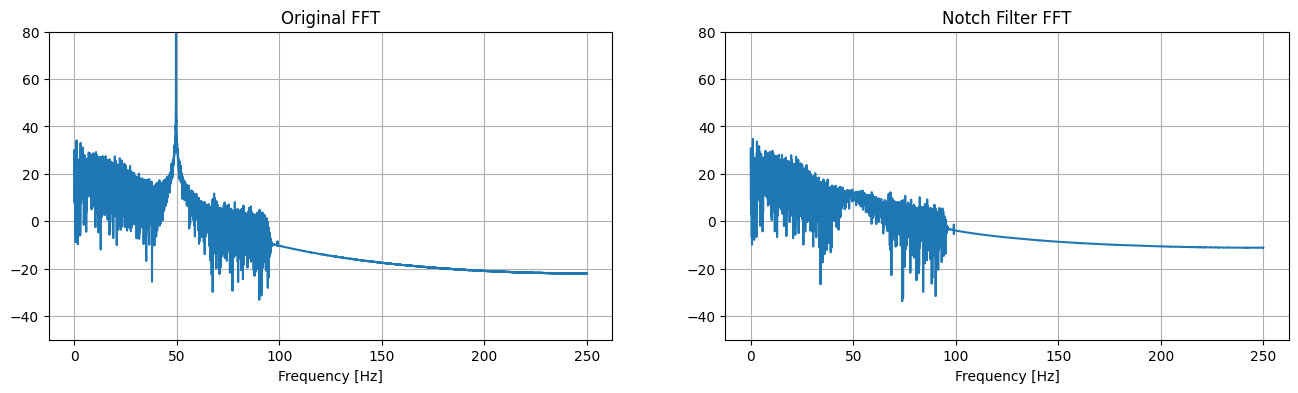

In [63]:
b0 = 1
Φ = (freq_max / 250)*np.pi #50/250π
r = 0.9
num_notch = np.array([1, -2*np.cos(Φ), 1]) * b0
den_notch = np.array([1, -2*r*np.cos(Φ), r**2])

ECG_notch = sig.lfilter(num_notch, den_notch, ecg_signal)

fig, ax = plt.subplots(1,2,figsize=(16,4))
f.plotMagResponse(num_notch, den_notch, db=True, ax=ax[0])
ax[0].grid()
ax[0].set_title("Notch Filter Magnitude Response")
ax[0].set_xlabel("Normalized Frequency [πx]")
ax[1].plot(t,ECG_notch)
ax[1].set_title("Notch Filtered ECG Data")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()

notch_fft = fft.fft(ECG_notch)
notch_freq = fft.fftfreq(N, 1/fs)[:N//2]
notch_db = 20*np.log10(2.0/N * abs(notch_fft[0:N//2]))

idx_max = np.argmax(notch_db)
notch_max = notch_freq[idx_max]
print("Frequency of maximum energy:",notch_max)

fig, ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(fft_freq, fft_db)
ax[0].set_ylim(-50,80)
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_title("Original FFT")
ax[0].grid()

ax[1].plot(notch_freq, notch_db)
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylim(-50,80)
ax[1].grid()
ax[1].set_title("Notch Filter FFT")
plt.show()

# 11)
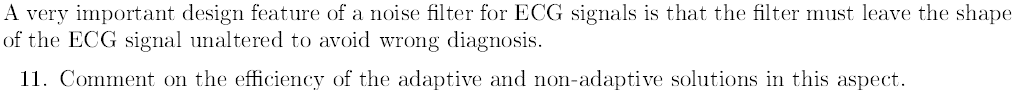

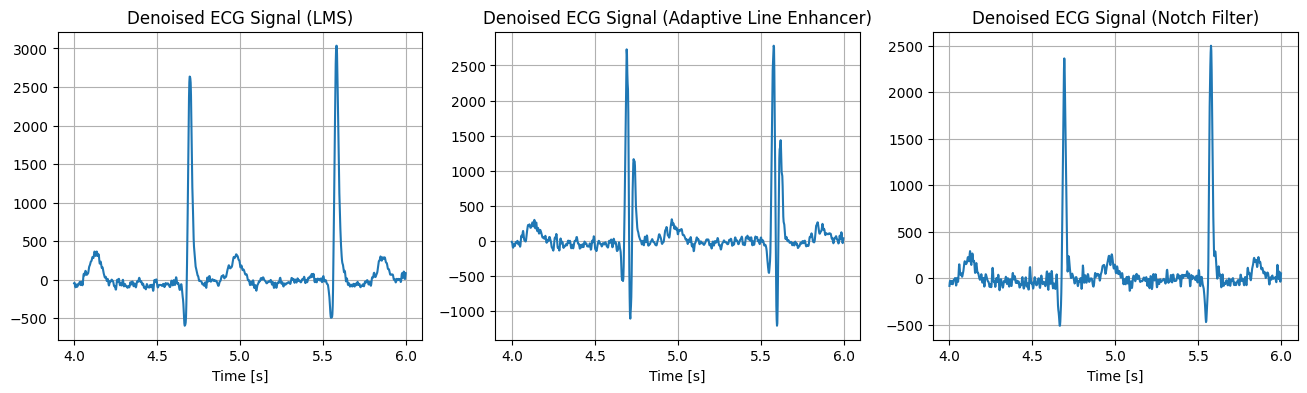

In [64]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(t[2000:3000], err2[2000:3000])
ax[0].set_title("Denoised ECG Signal (LMS)")
ax[0].set_xlabel("Time [s]")
ax[0].grid()
ax[1].plot(t[2000:3000], err_li[2000:3000])
ax[1].set_title("Denoised ECG Signal (Adaptive Line Enhancer)")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
ax[2].plot(t[2000:3000], ECG_notch[2000:3000])
ax[2].set_title("Denoised ECG Signal (Notch Filter)")
ax[2].set_xlabel("Time [s]")
ax[2].grid()

Frequency of maximum energy for ECG signal = 49.52695195447965


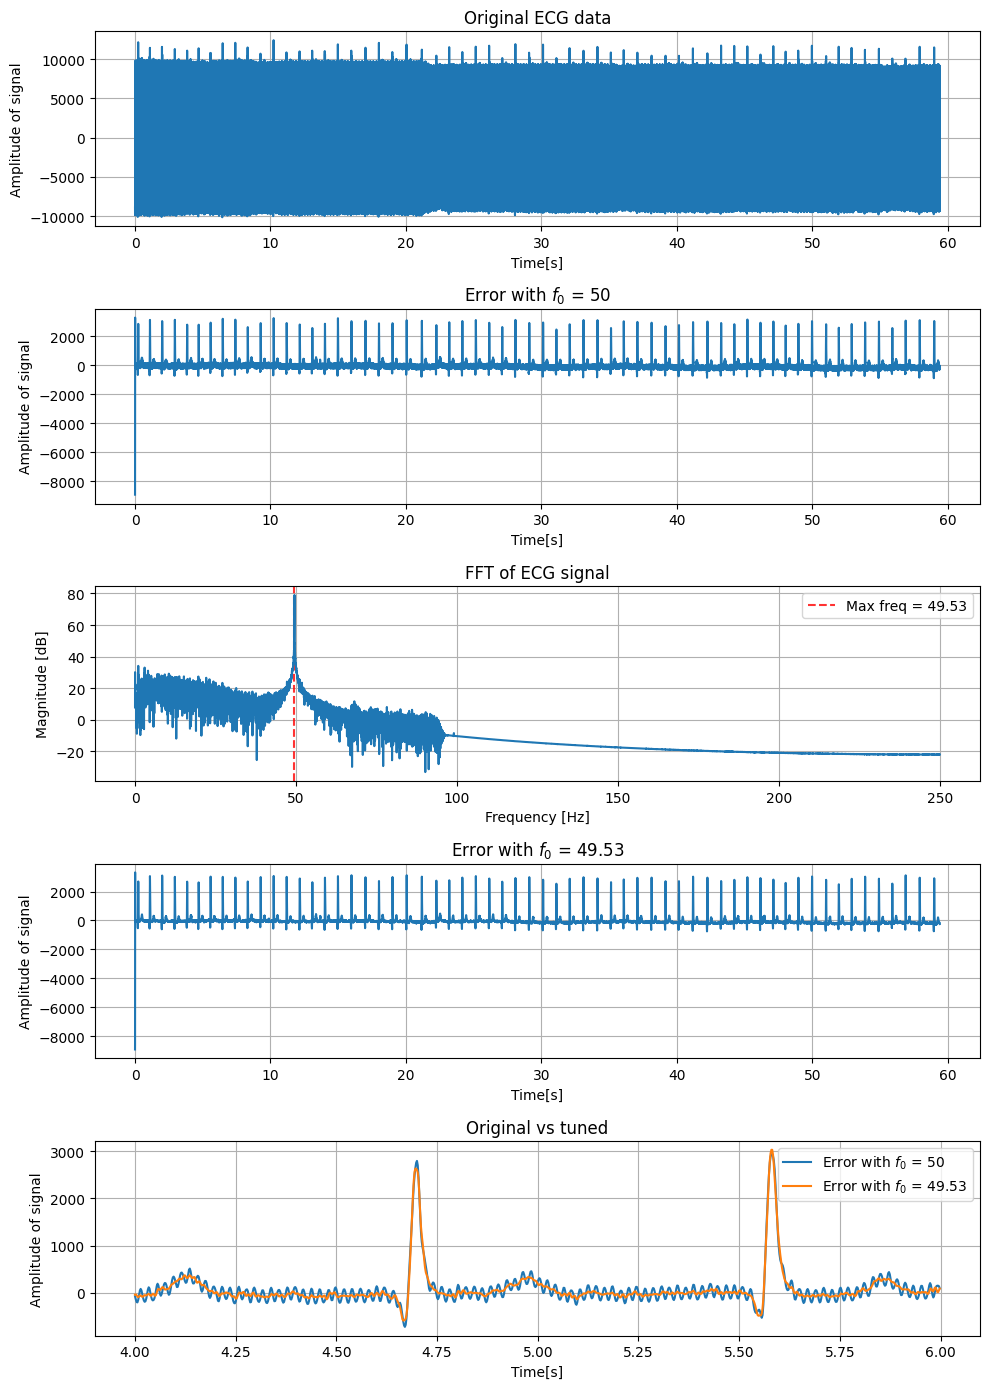

In [149]:
ecg_signal = np.loadtxt("ecg.dat") 
N = len(ecg_signal)
Nc = int(fs/f0)
f0 = 50 #Powerline noise frequency
fs = 500 #Sampling frequency of system
n_samples = len(ecg_signal)
t = np.arange(n_samples) / fs

# FFT ECG-signal
ecg_signal_fft, ecg_signal_fft_db,ecg_signal_freq_max = fft_data(ecg_signal)
print("Frequency of maximum energy for ECG signal =",ecg_signal_freq_max)

# Generate reference sinusoidal interference (50 Hz) for 50Hz and fft freq max
reference_signal_normal = np.cos(2 * np.pi * f0 * t)
reference_signal_fft = np.cos(2 * np.pi * ecg_signal_freq_max * t)

# Find stepsize µ for 50Hz and fft freq max
stepsize_normal = step_size(reference_signal_normal, Nc)
stepsize_fft = step_size(reference_signal_fft, Nc)

#Determined optimum weights with LMS
ws_normal, ys_normal, err_normal = LMS(reference_signal_normal, ecg_signal, Nc, stepsize_normal)
ws_fft, ys_fft, err_fft = LMS(reference_signal_fft, ecg_signal, Nc, stepsize_fft)

fig, ax = plt.subplots(5,1,figsize=(10,14))
ax[0].plot(t, ecg_signal)
ax[0].set_title("Original ECG data")
ax[0].set_xlabel("Time[s]")
ax[0].set_ylabel("Amplitude of signal")
ax[0].grid()
ax[1].plot(t, err_normal)
ax[1].set_title("Error with $f_0$ = 50")
ax[1].set_xlabel("Time[s]")
ax[1].set_ylabel("Amplitude of signal")
ax[1].grid()
ax[2].vlines(ecg_signal_freq_max, 0, 1, transform=ax[2].get_xaxis_transform(), colors='r', linestyles='dashed', alpha=0.8, label=f"Max freq = {ecg_signal_freq_max:.2f}")
ax[2].plot(ecg_signal_fft, ecg_signal_fft_db)
ax[2].set_title("FFT of ECG signal")
ax[2].set_xlabel("Frequency [Hz]")
ax[2].set_ylabel("Magnitude [dB]")
ax[2].legend()
ax[2].grid()
ax[3].plot(t, err_fft)
ax[3].set_title(f"Error with $f_0$ = {ecg_signal_freq_max:.2f}")
ax[3].set_xlabel("Time[s]")
ax[3].set_ylabel("Amplitude of signal")
ax[3].grid()
x1, x2 = 2000,3000
ax[4].plot(t[x1:x2],err_normal[x1:x2], label="Error with $f_0$ = 50")
ax[4].plot(t[x1:x2],err_fft[x1:x2], label=f"Error with $f_0$ = {ecg_signal_freq_max:.2f}")
ax[4].set_title("Original vs tuned")
ax[4].set_xlabel("Time[s]")
ax[4].set_ylabel("Amplitude of signal")
ax[4].grid()
ax[4].legend()
plt.tight_layout()
plt.show()

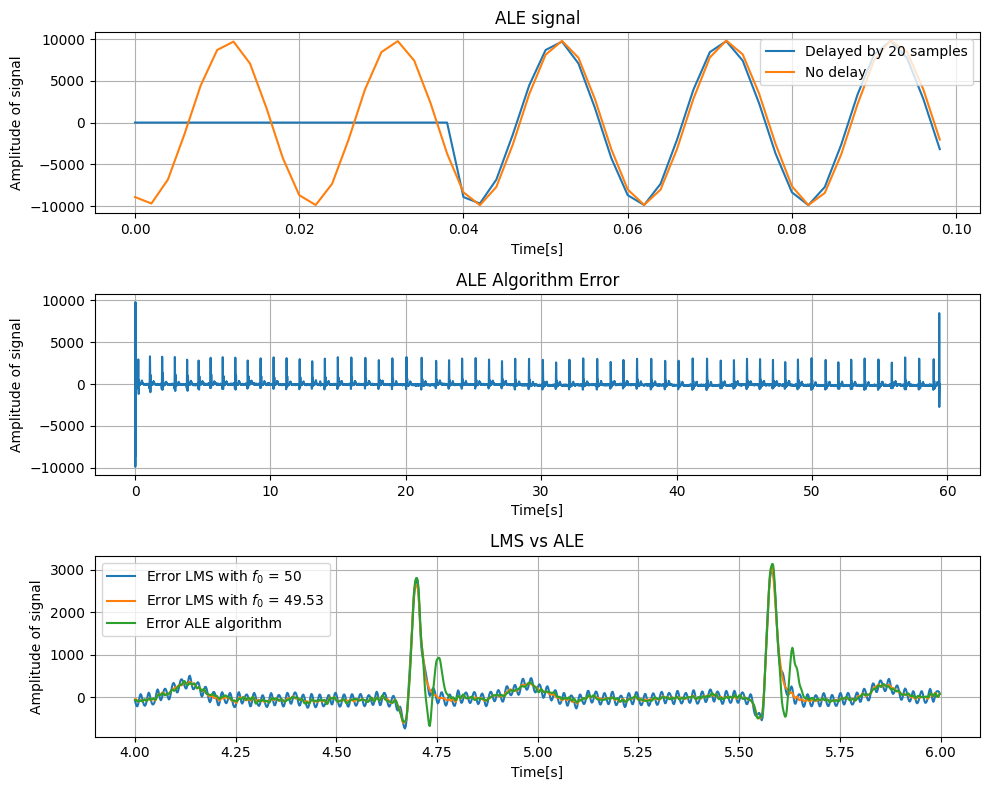

In [153]:
delay = 20
Nc_ALE = 10
ALE_signal, ALE_signal_delayed = ALE(ecg_signal, delay)
t_ale = np.arange(len(ALE_signal)) / fs

# Find stepsize µ for 50Hz and fft freq max
stepsize_ALE = step_size(ALE_signal, Nc_ALE)

#Determined optimum weights with LMS
ws_ALE, ys_ALE, err_ALE = LMS(ALE_signal_delayed, ALE_signal, Nc_ALE, stepsize_ALE)

fig, ax = plt.subplots(3,1,figsize=(10,8))
ax[0].plot(t_ale[0:50], ALE_signal_delayed[0:50],label=f"Delayed by {delay} samples")
ax[0].plot(t_ale[0:50], ALE_signal[0:50],label="No delay")
ax[0].set_title("ALE signal")
ax[0].set_xlabel("Time[s]")
ax[0].set_ylabel("Amplitude of signal")
ax[0].grid()
ax[0].legend(loc='upper right')
ax[1].plot(t_ale, err_ALE)
ax[1].set_title("ALE Algorithm Error")
ax[1].set_xlabel("Time[s]")
ax[1].set_ylabel("Amplitude of signal")
ax[1].grid()
x1, x2 = 2000,3000
ax[2].plot(t[x1:x2],err_normal[x1:x2], label="Error LMS with $f_0$ = 50")
ax[2].plot(t[x1:x2],err_fft[x1:x2], label=f"Error LMS with $f_0$ = {ecg_signal_freq_max:.2f}")
ax[2].plot(t_ale[x1:x2],err_ALE[x1:x2], label=f"Error ALE algorithm")
ax[2].set_title("LMS vs ALE")
ax[2].set_xlabel("Time[s]")
ax[2].set_ylabel("Amplitude of signal")
ax[2].grid()
ax[2].legend()
plt.tight_layout()
plt.show()

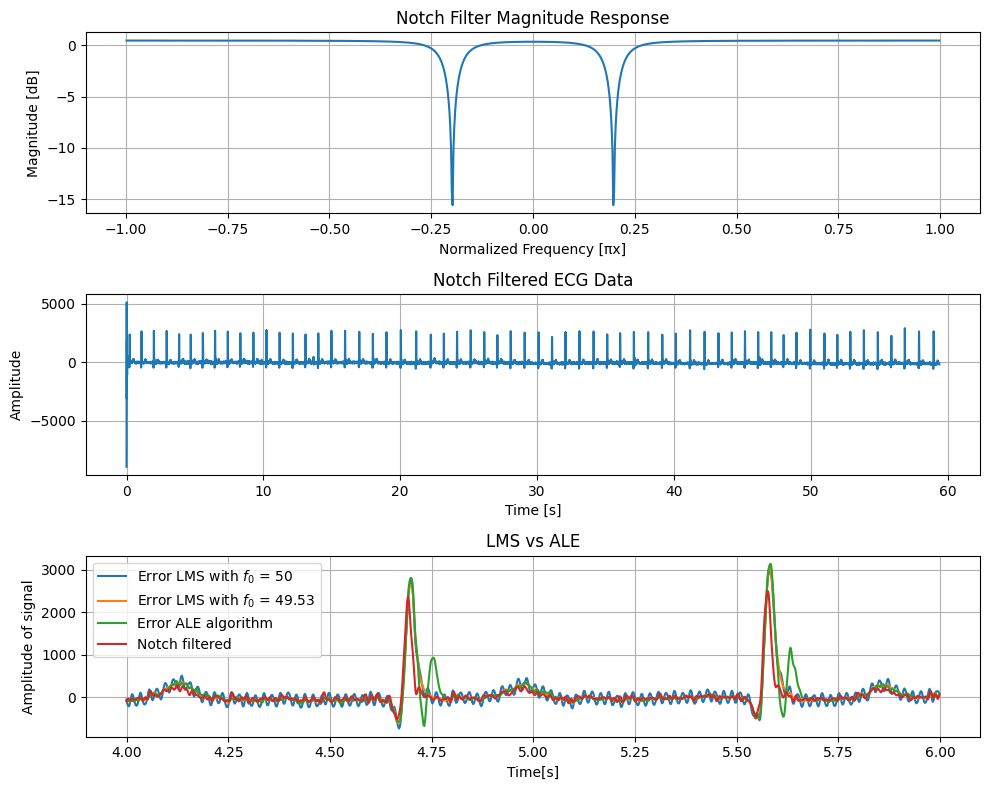

In [172]:
b0 = 1
r = 0.9
ECG_notch_filter = Notch_filter(ecg_signal,b0,r,ecg_signal_freq_max)
fig, ax = plt.subplots(3,1,figsize=(10,8))
f.plotMagResponse(num_notch, den_notch, db=True, ax=ax[0])
ax[0].grid()
ax[0].set_title("Notch Filter Magnitude Response")
ax[0].set_xlabel("Normalized Frequency [πx]")
ax[0].set_ylabel("Magnitude [dB]")
ax[1].plot(t,ECG_notch_filter)
ax[1].set_title("Notch Filtered ECG Data")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Amplitude")
ax[1].grid()
x1, x2 = 2000,3000
# ax[2].plot(t[x1:x2], ecg_signal[x1:x2], label="Unfiltered ECG signal")
ax[2].plot(t[x1:x2], err_normal[x1:x2], label="Error LMS with $f_0$ = 50")
ax[2].plot(t[x1:x2], err_fft[x1:x2], label=f"Error LMS with $f_0$ = {ecg_signal_freq_max:.2f}")
ax[2].plot(t_ale[x1:x2], err_ALE[x1:x2], label=f"Error ALE algorithm")
ax[2].plot(t[x1:x2],ECG_notch_filter[x1:x2], label="Notch filtered")
ax[2].set_title("LMS vs ALE")
ax[2].set_xlabel("Time[s]")
ax[2].set_ylabel("Amplitude of signal")
ax[2].grid()
ax[2].legend()
plt.tight_layout()
plt.show()

In [187]:
ECG_SNR = calculate_snr(reference_signal_normal, ecg_signal-reference_signal_normal)
LMS_SNR = calculate_snr(err_normal, ecg_signal-err_normal)
LMS_tuned_SNR = calculate_snr(err_fft, ecg_signal-err_fft)
Notch_SNR = calculate_snr(ECG_notch_filter,ecg_signal-ECG_notch_filter)
print(f"ECG SNR = {ECG_SNR}")
print(f"LMS SNR = {LMS_SNR}")
print(f"Tuned LMS SNR = {LMS_tuned_SNR}")
print(f"Notch filtered SNR = {Notch_SNR}")

ECG SNR = -79.56442138893108
LMS SNR = -23.507719477635685
Tuned LMS SNR = -23.763865564322334
Notch filtered SNR = -26.055362243275226


In [154]:
def Notch_filter(signal,b0, r, freq):
    Φ = (freq / 250)*np.pi #50/250π
    num_notch = np.array([1, -2*np.cos(Φ), 1]) * b0
    den_notch = np.array([1, -2*r*np.cos(Φ), r**2])
    notch = sig.lfilter(num_notch, den_notch, signal)
    return notch

def ALE(signal,delay):
    """
    Generate the delayed reference signal. 
    """
    desired_signal = np.append(signal, [0] * delay)
    desired_signal_delayed = np.insert(signal, 0, [0] * delay)
    return desired_signal, desired_signal_delayed

def step_size(signal, Nc):
    """
    Calculate the maximum stepsize.
    Inputs: signal, Number of filter coefficients (Nc).
    """
    ACR, _ = f.autocorrelation(signal, Nc)
    R = sp.linalg.toeplitz(np.flip(ACR[:Nc]))
    μ_max = 1/(3*np.trace(R))
    return µ_max

def fft_data(signal):
    """
    Calculate FFT and max frequency. 
    """
    data_fft = fft.fft(signal)
    fft_freq = fft.fftfreq(N, 1/fs)[:N//2]
    fft_db = 20*np.log10(2.0/N * abs(data_fft[0:N//2]))
    idx_max = np.argmax(fft_db)
    freq_max = fft_freq[idx_max]
    return fft_freq, fft_db,freq_max

def calculate_snr(signal, noise):
    """
    Calculate Signal-to-Noise Ratio (SNR) in dB.
    """
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def LMS(x, d, order, step): 
    """
    Inputs: data sequence (x), desired signal (d), number of filter taps (order), step-size (step).
    Outputs: weights (ws), filter output (ys), error output (error).
    """
    N = len(x)
    ws = np.zeros((N, order))
    ys = np.zeros(N)
    error = np.zeros(N)
    w = np.zeros(order)
    x_in = np.zeros(order)
    for k in range(N):
        ws[k] = w
        x_in = np.insert(x_in, 0, x[k])
        x_in = np.delete(x_in, -1)
        ys[k] = np.dot(w, x_in)
        error[k] = d[k] - ys[k]
        w = w + 2*step*error[k]*x_in
    return ws, ys, error